In [42]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout,AdaptiveAvgPool2d
from torch.optim import Adam, SGD
import torch.nn.functional as F
from torchvision import models

import time
from sklearn.metrics import accuracy_score
import random
import os, sys
from matplotlib import pyplot as plt
from scipy import interpolate

import cca_core
import geotransfer
from scipy import interpolate

## Functions to get activation vectors from a test image with the model

In [2]:
class SaveOutput:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        
    def clear(self):
        self.outputs = []

In [99]:
def get_all_activations(model,layers,img,fraction=1.0):
     """Get all activation vectors over images for a model.

    :param model: A pytorch model 
    :type model: currently is Net defined by ourselves
    :param layers: One or more layers that activations are desired
    :type layers: torch.nn.modules.container.Sequential
    :param img: A 4-d tensor containing the test datapoints from which activations are desired. 
                The 1st dimension should be the number of test datapoints.
                The next 3 dimensions should match the input of the model
    :type img: torch.Tensor
    :param fraction: If defined, then a random fraction of img will be chosen.
    :type fraction: float
    :return (output): A list containing activations of all specified layers.
    """
    l = len(img)
    num_imgs = round(l*fraction)
    img_sub = img[torch.tensor(random.sample(range(l),num_imgs))]
    img_sub = torch.from_numpy(np.array(img_sub,dtype='f'))
    
    save_output = SaveOutput()
    hook_handles = []

    for layer in layers:
        handle = layer.register_forward_hook(save_output)
        hook_handles.append(handle)
        
    out = model(img_sub)
    output = save_output.outputs.copy()
    
    del save_output,hook_handles,out
    return output

In [157]:
def get_svf_acts(acts = None, # should be a np.array
                 all_acts = None,
                 layer_num = 0, dim = 20):
    """Prepare the input for computing SVCCA from an existing activation.

    :acts: An 4d array of activations. If not specified, then all_acts and layer_num should be specified. 
                                         If specified, then all_acts and layer_num need not be specified.
    :type acts: numpy.ndarray
    :param all_acts: A list of 4-d activations. Usually the output of get_all_activations. 
    :type all_acts: list
    :layer_num: Defines which layer(s) of all_acts is desired
    :type layer: int
    :dim: How many dimenstions will be used.
    :return svf_acts: A 2d numpy.ndarray. The first dimension is param dim. 
    :return svb: A 2d numpy.ndarray of baselines.
    """
    if acts is None:
        acts = np.array(all_acts[torch.tensor([layer_num])])
    num_datapoints, h, w, channels = acts.shape
    
    f_acts = acts.reshape((num_datapoints*h*w, channels))
    
    # Mean subtract activations
    cf_acts = f_acts - np.mean(f_acts, axis=1, keepdims=True)
    
    # Perform SVD
    U, s, V = np.linalg.svd(cf_acts, full_matrices=False)
    
    svf_acts = np.dot(s[:dim]*np.eye(dim), V[:dim])
    
    # creating a random baseline
    b = np.random.randn(*f_acts.shape)
    cb = b - np.mean(b, axis=0, keepdims=True)
    Ub, sb, Vb = np.linalg.svd(cb, full_matrices=False)
    svb = np.dot(sb[:20]*np.eye(20), Vb[:20])
    
    return svf_acts, svb

In [140]:
def plot_svcca_baseline(svcca_results, svcca_baseline):
    """
    plot the output of get_svf_acts
    """
    print("Baseline", np.mean(svcca_baseline["cca_coef1"]), "and our model", np.mean(svcca_results["cca_coef1"]))

    plt.plot(svcca_baseline["cca_coef1"], lw=2.0, label="baseline")
    plt.plot(svcca_results["cca_coef1"], lw=2.0, label="Our model")
    plt.xlabel("Sorted CCA Correlation Coeff Idx")
    plt.ylabel("CCA Correlation Coefficient Value")
    plt.legend(loc="best")
    plt.grid()

### Test the previously defined functions and call the cca_core.get_cca_similarity

In [7]:
test1 = np.load('/Volumes/ksankaran/sen12ms_subsample2/X_target_test.npy')
pic3 = test1[torch.tensor([0,1])]
pic3 = torch.from_numpy(np.array(pic3,dtype='f'))
pic = test1[torch.tensor([0,1,2,3])]

In [31]:
acts3.shape

torch.Size([2, 128, 128, 128])

In [10]:
import get_activations

In [5]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(13, 64, kernel_size=(5,5), stride=1, padding=2),BatchNorm2d(64),ReLU(inplace=True),MaxPool2d(kernel_size=(3,3), stride=(2,2),padding = 1),
            Conv2d(64, 128, kernel_size=(5,5), stride=1, padding=2),BatchNorm2d(128),ReLU(inplace=True),MaxPool2d(kernel_size=(3,3), stride=2, padding = 1),
            Conv2d(128, 256, kernel_size=(5,5), stride=1, padding=2),BatchNorm2d(256),ReLU(inplace=True),MaxPool2d(kernel_size=(3,3), stride=2, padding = 1),
            Conv2d(256, 512, kernel_size=(5,5), stride=1, padding=2),BatchNorm2d(512),ReLU(inplace=True),MaxPool2d(kernel_size=(3,3), stride=2, padding = 1),
            AdaptiveAvgPool2d((1, 1)))
        self.linear_layers = Sequential(
            Linear(in_features= 512, out_features=8, bias = True))
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [6]:
mod2 = torch.load('/Volumes/ksankaran/sen12ms_subsample2/models/mod2.pt')

In [11]:
output1 = get_activations.get_all_activations(mod2,mod2.cnn_layers,pic3,fraction = 1)
output2 = get_activations.get_all_activations(mod2,mod2.cnn_layers,pic,fraction = 0.4)
len(output1),len(output2)

(17, 17)

In [12]:
svf_acts1, svb1 = get_activations.get_svf_acts(all_acts = output1, layer_num = 4, dim = 20)
svf_acts2, svb2 = get_activations.get_svf_acts(all_acts = output2, layer_num = 4, dim = 20)

In [20]:
svcca_results = cca_core.get_cca_similarity(svf_acts1, svf_acts2, epsilon=1e-10, verbose=False)
svcca_baseline = cca_core.get_cca_similarity(svb1, svb2, epsilon=1e-10, verbose=False)

Baseline 0.33216018015495646 and our model 0.8926461788133105


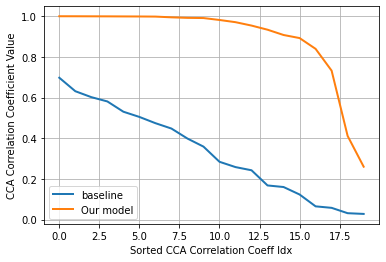

In [15]:
get_activations.plot_svcca_baseline(svcca_results, svcca_baseline)

## Different dimensions

### Compute the average cca from activations

In [244]:
def avg_cca(acts1,acts2):
    
    y = cca_core.get_cca_similarity(np.mean(np.array(acts1), axis=(1,2)),
                            np.mean(np.array(acts2), axis=(1,2)), 
                            epsilon=1e-10, verbose=False)
    return y

In [35]:
### Interpolate the smaller activation to the desired shape.

In [321]:
def reshape_acts(shape,
                 acts = None,
                 all_acts = None, 
                 layer_num = None):
    '''
    :param shape: The desired shape.
    :param acts: A 4d array. If specified, then all_acts and layer_num need not be specified. Othervise they should.
    :type acts: numpay.ndarray
    :param all_acts: A list of 4d tensors.
    :type all_acts:list
    :param layer_num: Indicates activations of which layer will be used.
    :type layer_num: int
    :return act_interp: the interpolated 4d activations with the desired shape.
    '''
    if acts is None:
        acts = np.array(all_acts[torch.tensor([layer_num])])
    
    num_d, h, w, _ = shape
    num_c = acts.shape[-1]
    acts_interp = np.zeros((num_d, h, w, num_c))
    for d in range(num_d):
        for c in range(num_c):
            # form interpolation function
            idxs1 = np.linspace(0, acts.shape[1],
                            acts.shape[1],
                            endpoint=False)
            idxs2 = np.linspace(0, acts.shape[2],
                            acts.shape[2],
                            endpoint=False)
            arr = acts[d,:,:,c]
            f_interp = interpolate.interp2d(idxs2, idxs1, arr)
        
            # creater larger arr
            large_idxs1 = np.linspace(0, acts.shape[1],
                            acts.shape[1],
                            endpoint=False)
            large_idxs2 = np.linspace(0, acts.shape[2],
                            acts.shape[2],
                            endpoint=False)
        
            acts_interp[d, :, :, c] = f_interp(large_idxs1, large_idxs2)
        
    return acts_interp

### Test the previously defined functions

In [44]:
get_activations.get_all_activations(mod2,mod2.cnn_layers,pic3,fraction = 1)

[tensor([[[[  -51.8642,   -15.1945,   233.3753,  ...,   276.2842,
             -253.4484,  -117.4841],
           [ -466.2783,  -570.1133,   -87.1960,  ...,  -153.4176,
             -449.1480,  -132.0737],
           [  -48.0073,  -108.0842,   710.5042,  ...,   697.3632,
              254.3344,   672.9597],
           ...,
           [  -36.5786,   -44.4942,   398.5549,  ...,   749.1324,
              248.4248,   403.1187],
           [  -19.5913,  -170.7888,   512.9837,  ...,   732.5894,
              257.0720,   413.2212],
           [  129.6496,    88.9278,   624.8342,  ...,   868.1864,
              674.0282,   675.0778]],
 
          [[ -596.9988,  -645.1866,  -344.7982,  ...,  -475.2902,
             -608.2346,  -468.2574],
           [ -520.5247,  -787.7139,  -634.5138,  ...,  -719.8317,
            -1147.6882,  -982.0636],
           [ -684.2814, -1034.2019,  -593.8546,  ...,  -716.5347,
            -1097.3973,  -952.1287],
           ...,
           [ -508.4478,  -781.8375,  -

In [16]:
output3 = get_activations.get_all_activations(mod2,mod2.cnn_layers,pic3,fraction = 1)
output4 = get_activations.get_all_activations(mod2,mod2.cnn_layers,pic,fraction = 1)
len(output3),len(output4)

(17, 17)

In [22]:
type(mod2.cnn_layers)

torch.nn.modules.container.Sequential

In [17]:
acts3 = output3[torch.tensor([4])]
acts4 = output4[torch.tensor([4])]
acts3.shape, acts4.shape

(torch.Size([2, 128, 128, 128]), torch.Size([4, 128, 128, 128]))

In [18]:
get_activations.avg_cca(acts3,acts4)

{'coef_x': array([[-0.62095521,  0.78384605],
        [ 0.78384605,  0.62095521]]),
 'invsqrt_xx': array([[ 1.77481598, -0.83517744],
        [-0.83517744,  1.49819709]]),
 'full_coef_x': array([[-0.62095521,  0.78384605],
        [ 0.78384605,  0.62095521]]),
 'full_invsqrt_xx': array([[ 1.77481598, -0.83517744],
        [-0.83517744,  1.49819709]]),
 'coef_y': array([[-0.00825887, -0.14432697, -0.60212161,  0.78520767],
        [ 0.38992117,  0.45694391,  0.58945252,  0.54010136],
        [-0.88509604, -0.04880637,  0.37593226,  0.26999605],
        [ 0.2539651 , -0.87635035,  0.38557779,  0.13726457]]),
 'invsqrt_yy': array([[ 2.54184297, -0.53342259, -0.62436644, -0.45853848],
        [-0.53342259,  2.21374758, -0.96642302, -0.45286896],
        [-0.62436644, -0.96642302,  2.78811898, -0.41270356],
        [-0.45853848, -0.45286896, -0.41270356,  1.83144963]]),
 'full_coef_y': array([[-0.00825887, -0.14432697, -0.60212161,  0.78520767],
        [ 0.38992117,  0.45694391,  0.5894525

In [38]:
acts5 = get_activations.reshape_acts(shape = acts3.shape,acts = acts4)

In [39]:
svf_acts3, svb3 = get_activations.get_svf_acts(acts = np.array(acts3), dim = 20)
svf_acts5, svb5 = get_activations.get_svf_acts(acts = np.array(acts5), dim = 20)

In [40]:
svcca_results = cca_core.get_cca_similarity(svf_acts3, svf_acts5, epsilon=1e-10, verbose=False)
svcca_baseline = cca_core.get_cca_similarity(svb3, svb5, epsilon=1e-10, verbose=False)

Baseline 0.3490273510885028 and our model 0.8762819369397958


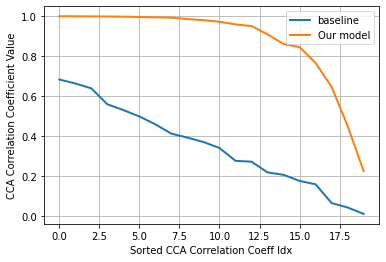

In [41]:
get_activations.plot_svcca_baseline(svcca_results, svcca_baseline)